In [1]:
import matplotlib.pyplot as plt
import cv2
import numpy as np
from scipy.signal import correlate2d

In [2]:
def normalize(array):
    return (array - np.mean(array)) / np.std(array)

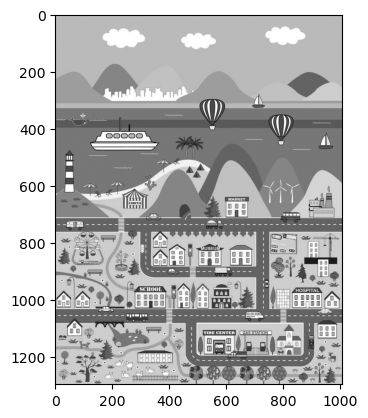

In [3]:
map_image = cv2.imread('map.jpg', cv2.IMREAD_GRAYSCALE)
plt.imshow(map_image, 'gray')
plt.show()

In [4]:
baloon = map_image[297:407,507:597]
nbaloon = normalize(baloon)
nmap_image = normalize(cv2.equalizeHist(map_image))

In [5]:
corr_map = correlate2d(nmap_image, nbaloon)

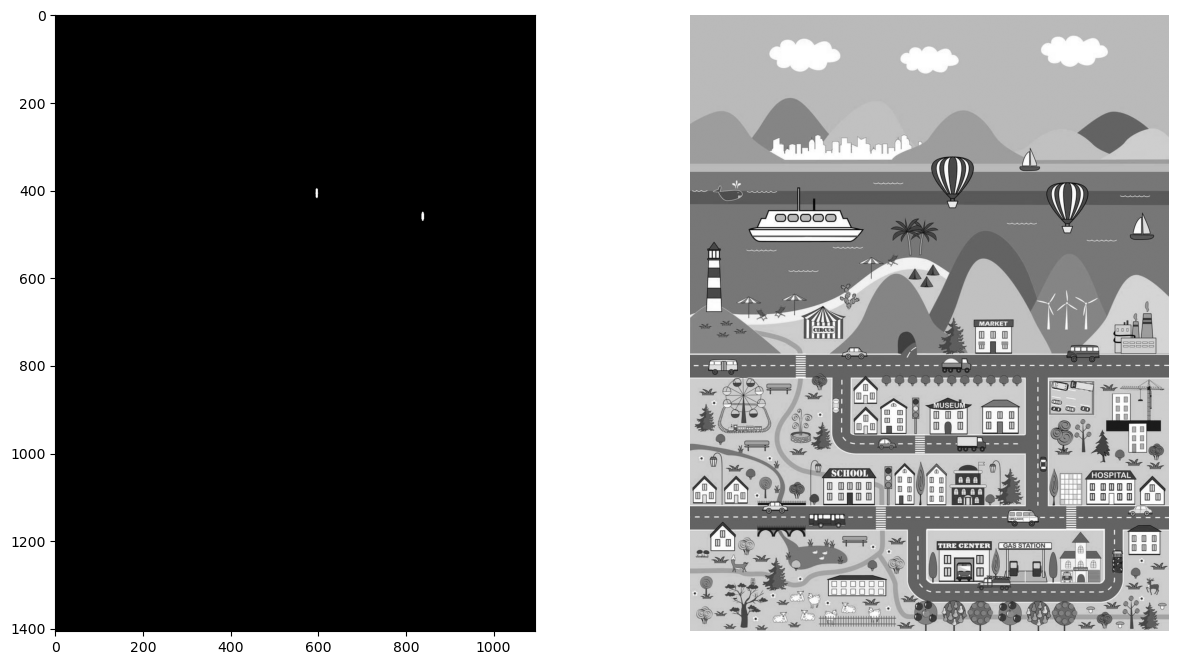

In [6]:
res = (corr_map >= 3000).astype(np.uint8)
_, (ax1, ax2) = plt.subplots(1,2, figsize=(15,8))
ax1.imshow(res, 'gray', vmin=0, vmax=1)
ax2.axis('off')
ax2.imshow(map_image , 'gray')
plt.show()

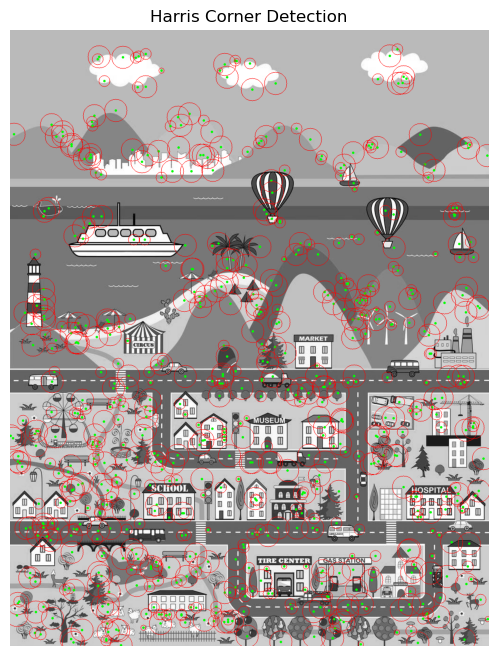

In [7]:
def harris(image, k, ksize, p, s, s_min):
    dx = cv2.Sobel(image, cv2.CV_64F, 1, 0, ksize=ksize)
    dy = cv2.Sobel(image, cv2.CV_64F, 0, 1, ksize=ksize)
    dx2 = dx ** 2
    dy2 = dy ** 2
    h_score = (dx2*dy2)-((dx*dy)**2)-k*((dx2+dy2)**2)
    t = np.percentile(h_score.ravel(), p)
    h_score_t = np.where(h_score > t, h_score, 0)


    candidate_xy = []
    for y,x in np.argwhere(h_score_t):
        if (h_score[max(0,y-1):y+2, max(0,x-1):x+2] < h_score[y,x]).sum()==8:
            candidate_xy.append((y, x))

    image64 = image.astype(np.float64)

    norm_lap = []
    sigmas = 2**np.arange(s_min, s) # 2**i, i=0..s-1
    for s in sigmas:
        blurred = cv2.GaussianBlur(image64, (0, 0), s)
        lap = cv2.Laplacian(blurred, cv2.CV_64F, ksize=5)
        norm_lap.append((s ** 2) * np.abs(lap))
    norm_lap = np.stack(norm_lap, axis=0)

    keypoints = []
    for (y, x) in candidate_xy:
        s_idx = np.argmax(norm_lap[:, y, x])
        keypoints.append((y, x, sigmas[s_idx]))
    return keypoints

def draw_harris(image, k, ksize, p, s, s_min=0):
    keypoints = harris(image, k, ksize, p, s, s_min)
    rgb_image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)
    for (y, x, sigma) in keypoints:
        r = 3 * sigma
        cv2.circle(rgb_image, (int(x), int(y)), r, (255, 0, 0), 1)
        cv2.circle(rgb_image, (int(x), int(y)), 1, (0, 255, 0), 2)
    plt.figure(figsize=(15, 8))
    plt.imshow(rgb_image)
    plt.axis('off')
    plt.title('Harris Corner Detection')
    plt.show()

draw_harris(map_image, 0.05, 5, 57.5, 4)

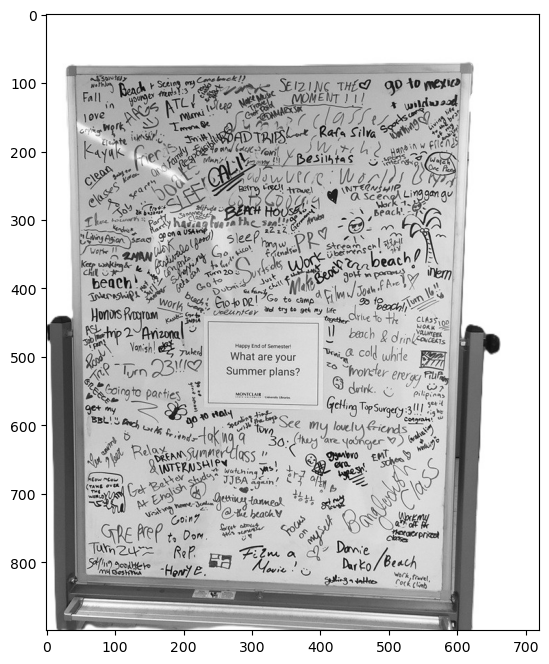

In [8]:
board_image = cv2.imread('Whiteboard.jpg', cv2.IMREAD_GRAYSCALE)
plt.figure(figsize=(12,8))
plt.imshow(board_image, 'gray')
plt.show()

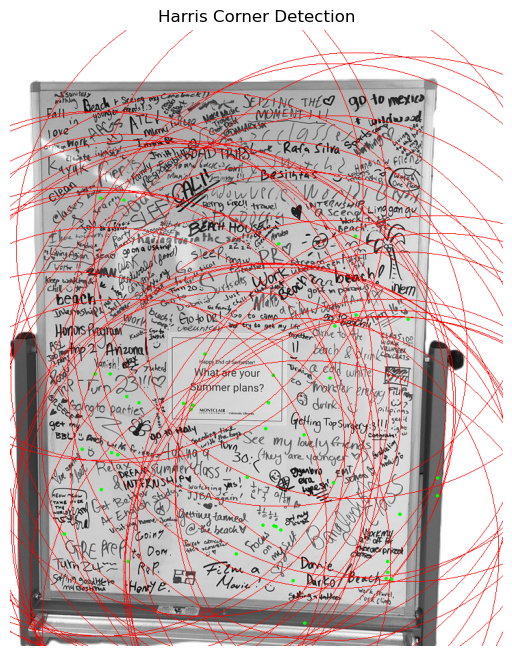

In [9]:
draw_harris(board_image, 0.06, 21, 80.5, 8, 7) # If only I could've found the right parmaters. This part is a cam scanner demo program.